# Intake / Pangeo Catalog: Making It Easier To Consume Earth’s Climate and Weather Data

Anderson Banihirwe (abanihi@ucar.edu), Charles Blackmon-Luca (blackmon@ldeo.columbia.edu), Ryan Abernathey (rpa@ldeo.columbia.edu), Joseph Hamman (jhamman@ucar.edu)

- NCAR, Boulder, CO, USA
- Columbia University, Palisades, NY, USA

[2020 EarthCube Annual Meeting](https://www.earthcube.org/EC2020) ID: 133


## Introduction

Computer simulations of the Earth’s climate and weather generate huge amounts of data. These data are often persisted on high-performance computing (HPC) systems or in the cloud across multiple data assets in a variety of formats (netCDF, Zarr, etc.). 
Finding, investigating, and loading these data assets into compute-ready data containers costs time and effort. 
The user should know what data are available and their associated metadata, preferably before loading a specific data asset and analyzing it. 

In this notebook, we demonstrate [intake-esm](https://github.com/NCAR/intake-esm), a Python package and an [intake](https://github.com/intake/intake) plugin with aims of facilitating:

- the discovery of earth's climate and weather datasets.
- the ingestion of these datasets into [xarray](https://github.com/pydata/xarray) dataset containers.

The common/popular starting point for finding and investigating large datasets is with a data catalog. 
A *data catalog* is a collection of metadata, combined with search tools, that helps data analysts and other users to find the data they need. 
For a user to take full advantage of intake-esm, they must point it to an *Earth System Model (ESM) data catalog*. 
This is a JSON-formatted file that conforms to the ESM collection specification.

## ESM Collection Specification

The [ESM collection specification](https://github.com/NCAR/esm-collection-spec) provides a machine-readable format for describing a wide range of climate and weather datasets, with a goal of making it easier to index and discover climate and weather data assets. 
An asset is any netCDF/HDF file or Zarr store that contains relevant data.

An ESM data catalog serves as an inventory of available data, and provides information to explore the existing data assets. 
Additionally, an ESM catalog can contain information on how to aggregate compatible groups of data assets into singular xarray datasets. 

## Use Case: CMIP6 hosted on Google Cloud

The Coupled Model Intercomparison Project (CMIP) is an international collaborative effort to improve the knowledge about climate change and its impacts on the Earth System and on our society. 
[CMIP began in 1995](https://www.wcrp-climate.org/wgcm-cmip), and today we are in its sixth phase (CMIP6). 
The CMIP6 data archive consists of data models created across approximately 30 working groups and 1,000 researchers investigating the urgent environmental problem of climate change, and will provide a wealth of information for the next Assessment Report (AR6) of the [Intergovernmental Panel on Climate Change](https://www.ipcc.ch/) (IPCC).

Last year, Pangeo partnered with Google Cloud to bring CMIP6 climate data to Google Cloud’s Public Datasets program. 
You can read more about this process [here](https://cloud.google.com/blog/products/data-analytics/new-climate-model-data-now-google-public-datasets).
For the remainder of this section, we will demonstrate intake-esm's features using the ESM data catalog for the CMIP6 data stored on Google Cloud Storage. 
This catalog resides [in a dedicated CMIP6 bucket](https://storage.googleapis.com/cmip6/pangeo-cmip6.json).

### Loading an ESM data catalog

To load an ESM data catalog with intake-esm, the user must provide a valid ESM data catalog as input:

In [1]:
import warnings
warnings.filterwarnings("ignore")

import intake

col = intake.open_esm_datastore('https://storage.googleapis.com/cmip6/pangeo-cmip6.json')
col

,unique
activity_id,15
institution_id,33
source_id,73
experiment_id,103
member_id,169
table_id,29
variable_id,370
grid_label,10
zstore,269868
dcpp_init_year,60


The summary above tells us that this catalog contains over 268,000 data assets.
We can get more information on the individual data assets contained in the catalog by calling the underlying dataframe created when it is initialized:

In [2]:
col.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
0,AerChemMIP,AS-RCEC,TaiESM1,histSST,r1i1p1f1,AERmon,od550aer,gn,gs://cmip6/AerChemMIP/AS-RCEC/TaiESM1/histSST/...,NaN
1,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrbc,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN
2,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrdust,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN
3,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmroa,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN
4,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrso4,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN


The first data asset listed in the catalog contains:

- the ambient aerosol optical thickness at 550nm (`variable_id='od550aer'`), as a function of latitude, longitude, time,
- in an individual climate model experiment with the Taiwan Earth System Model 1.0 model (`source_id='TaiESM1'`),
- forced by the *Historical transient with SSTs prescribed from historical* experiment (`experiment_id='histSST'`),
- developed by the Taiwan Research Center for Environmental Changes (`instution_id='AS-RCEC'`),
- run as part of the Aerosols and Chemistry Model Intercomparison Project (`activity_id='AerChemMIP'`)

And is located in Google Cloud Storage at `gs://cmip6/AerChemMIP/AS-RCEC/TaiESM1/histSST/r1i1p1f1/AERmon/od550aer/gn/`.

Note: the amount of details provided in the catalog is determined by the data provider who builds the catalog. 

### Searching for datasets

After exploring the [CMIP6 controlled vocabulary](https://github.com/WCRP-CMIP/CMIP6_CVs), it’s straightforward to get the data assets you want using intake-esm's `search()` method. In the example below, we are are going to search for the following:

- variables: `tas` which stands for near-surface air temperature
- experiments: `['historical', 'ssp245', 'ssp585']`: 
     - `historical`: all forcing of the recent past.
     - `ssp245`: update of [RCP4.5](https://en.wikipedia.org/wiki/Representative_Concentration_Pathway) based on SSP2.
     - `ssp585`: emission-driven [RCP8.5](https://en.wikipedia.org/wiki/Representative_Concentration_Pathway) based on SSP5.
- table_id: `Amon` which stands for Monthly atmospheric data.
- grid_label: `gr` which stands for regridded data reported on the data provider's preferred target grid.
     
For more details on the CMIP6 vocabulary, please check this [website](http://clipc-services.ceda.ac.uk/dreq/index.html).

In [3]:
# form query dictionary
query = dict(experiment_id=['historical', 'ssp245', 'ssp585'],
             table_id='Amon',
             variable_id=['tas'],
             member_id = 'r1i1p1f1',
             grid_label='gr')

# subset catalog and get some metrics grouped by 'source_id'
col_subset = col.search(require_all_on=['source_id'], **query)
col_subset.df.groupby('source_id')[['experiment_id', 'variable_id', 'table_id']].nunique()

,experiment_id,variable_id,table_id
source_id,,,
CIESM,3,1,1
EC-Earth3,3,1,1
EC-Earth3-Veg,3,1,1
FGOALS-f3-L,3,1,1
IPSL-CM6A-LR,3,1,1
KACE-1-0-G,3,1,1


### Loading datasets

Once you've identified data assets of interest, you can load them into xarray dataset containers using the `to_dataset_dict()` method. Invoking this method yields a Python dictionary of high-level aggregated xarray datasets. 
The logic for merging/concatenating the query results into higher level xarray datasets is provided in the input JSON file, under `aggregation_control`:

```json

"aggregation_control": {
  "variable_column_name": "variable_id",
  "groupby_attrs": [
    "activity_id",
    "institution_id",
    "source_id",
    "experiment_id",
    "table_id",
    "grid_label"
  ],
  "aggregations": [{
      "type": "union",
      "attribute_name": "variable_id"
    },

    {
      "type": "join_new",
      "attribute_name": "member_id",
      "options": {
        "coords": "minimal",
        "compat": "override"
      }
    },
    {
      "type": "join_new",
      "attribute_name": "dcpp_init_year",
      "options": {
        "coords": "minimal",
        "compat": "override"
      }
    }
  ]
}

```

Though these aggregation specifications are sufficient to merge individual data assets into xarray datasets, sometimes additional arguments must be provided depending on the format of the data assets.
For example, Zarr-based assets can be loaded with the option `consolidated=True`, which relies on a consolidated metadata file to describe the assets with minimal data egress.

In [4]:
dsets = col_subset.to_dataset_dict(zarr_kwargs={'consolidated': True}, storage_options={'token': 'anon'})

# list all merged datasets
[key for key in dsets.keys()]


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


['ScenarioMIP.CAS.FGOALS-f3-L.ssp245.Amon.gr',
 'ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp245.Amon.gr',
 'ScenarioMIP.EC-Earth-Consortium.EC-Earth3.ssp585.Amon.gr',
 'ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp585.Amon.gr',
 'CMIP.IPSL.IPSL-CM6A-LR.historical.Amon.gr',
 'CMIP.EC-Earth-Consortium.EC-Earth3.historical.Amon.gr',
 'ScenarioMIP.NIMS-KMA.KACE-1-0-G.ssp245.Amon.gr',
 'ScenarioMIP.EC-Earth-Consortium.EC-Earth3-Veg.ssp245.Amon.gr',
 'ScenarioMIP.THU.CIESM.ssp585.Amon.gr',
 'CMIP.EC-Earth-Consortium.EC-Earth3-Veg.historical.Amon.gr',
 'ScenarioMIP.THU.CIESM.ssp245.Amon.gr',
 'ScenarioMIP.EC-Earth-Consortium.EC-Earth3.ssp245.Amon.gr',
 'ScenarioMIP.EC-Earth-Consortium.EC-Earth3-Veg.ssp585.Amon.gr',
 'CMIP.NIMS-KMA.KACE-1-0-G.historical.Amon.gr',
 'ScenarioMIP.NIMS-KMA.KACE-1-0-G.ssp585.Amon.gr',
 'ScenarioMIP.CAS.FGOALS-f3-L.ssp585.Amon.gr',
 'CMIP.CAS.FGOALS-f3-L.historical.Amon.gr',
 'CMIP.THU.CIESM.historical.Amon.gr']

When the datasets have finished loading, we can extract any of them like we would a value in a Python dictionary:

In [5]:
ds = dsets['ScenarioMIP.THU.CIESM.ssp585.Amon.gr']
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 192, lon: 288, member_id: 1, time: 1032)
Coordinates:
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
    time_bnds  (time, bnds) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
    height     float64 ...
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * member_id  (member_id) <U8 'r1i1p1f1'
Dimensions without coordinates: bnds
Data variables:
    tas        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 303, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             ScenarioMIP
    branch_method:           standard
    branch_time_in_child:    735110.0
    branch_time_in_parent:   735110.0
    cmor_version:            3.5.0
    contact:                 yanluan@tsinghua.edu.cn
    creation_date:           2020-03-23T02:29:28Z
    data_specs_version:      01.00.29
    experiment:              update of RCP8.5 based on SSP5
    experiment_id:           ssp585
    external_variables:      areacella
    forcing_index:           1
    frequency:               mon
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.THU.CIESM.s...
    grid:                    gs1x1
    grid_label:              gr
    history:                 2020-03-23T02:29:28Z ;rewrote data to be consist...
    initialization_index:    1
    institution:             Department of Earth System Science, Tsinghua Uni...
    institution_id:          THU
    license:                 CMIP6 model data produced by Department of Earth...
    mip_era:                 CMIP6
    nominal_resolution:      100 km
    parent_activity_id:      CMIP
    parent_experiment_id:    historical
    parent_mip_era:          CMIP6
    parent_source_id:        CIESM
    parent_time_units:       days since 0001-01-01
    parent_variant_label:    r1i1p1f1
    physics_index:           1
    product:                 model-output
    realization_index:       1
    realm:                   atmos
    run_variant:             1rd realization
    source:                  CIESM (2019): \naerosol: prescribed MACv2-SP\nat...
    source_id:               CIESM
    source_type:             AOGCM
    status:                  2020-05-01;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:          none
    sub_experiment_id:       none
    table_id:                Amon
    table_info:              Creation Date:(20 February 2019) MD5:510997cd0a2...
    title:                   CIESM output prepared for CMIP6
    tracking_id:             hdl:21.14100/eba65a5e-f036-487a-a96e-757e2293ed66
    variable_id:             tas
    variant_label:           r1i1p1f1
    intake_esm_varname:      tas
    intake_esm_dataset_key:  ScenarioMIP.THU.CIESM.ssp585.Amon.gr

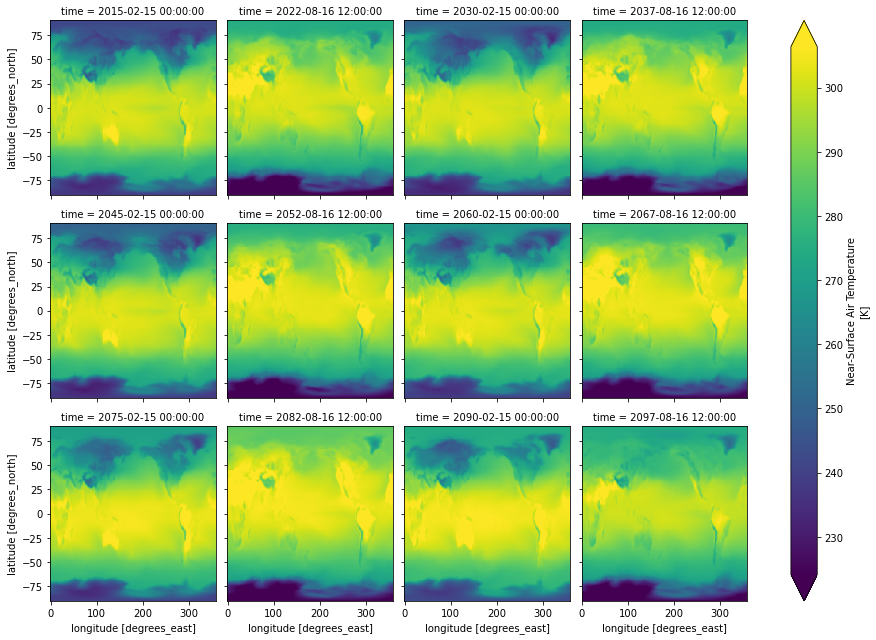

In [6]:
# Let’s create a quick plot for a slice of the data:
ds.tas.isel(time=range(1, 1000, 90))\
      .plot(col="time", col_wrap=4, robust=True)

## Pangeo Catalog

Pangeo Catalog is an open-source project to enumerate and organize cloud-optimized climate data stored across a variety of providers. 
In addition to offering various useful climate datasets in a consolidated location, the project also serves as a means of accessing public ESM data catalogs.

### Accessing catalogs using Python

At the core of the project is a [GitHub repository](https://github.com/pangeo-data/pangeo-datastore) containing several static intake catalogs in the form of YAML files.
Thanks to plugins like intake-esm and [intake-xarray](https://github.com/intake/intake-xarray), these catalogs can contain links to ESM data catalogs or data assets that can be loaded into xarray datasets, along with the arguments required to load them.

By editing these files using Git-based version control, anyone is free to contribute a dataset supported by the available [intake plugins](https://intake.readthedocs.io/en/latest/plugin-directory.html).
Users can then browse these catalogs by providing their associated URL as input into intake's `open_catalog()`; their tree-like structure allows a user to explore their entirety by simply opening the [root catalog](https://github.com/pangeo-data/pangeo-datastore/blob/master/intake-catalogs/master.yaml) and recursively walking through it:

In [7]:
cat = intake.open_catalog('https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/master.yaml')
entries = cat.walk(depth=5)

[key for key in entries.keys()]

['ocean.sea_surface_height',
 'ocean.cesm_mom6_example',
 'ocean.ECCOv4r3',
 'ocean.SOSE',
 'ocean.GODAS',
 'ocean.ECCO_layers',
 'ocean.altimetry.al',
 'ocean.altimetry.alg',
 'ocean.altimetry.c2',
 'ocean.altimetry.e1',
 'ocean.altimetry.e1g',
 'ocean.altimetry.e2',
 'ocean.altimetry.en',
 'ocean.altimetry.enn',
 'ocean.altimetry.g2',
 'ocean.altimetry.h2',
 'ocean.altimetry.j1',
 'ocean.altimetry.j1g',
 'ocean.altimetry.j1n',
 'ocean.altimetry.j2',
 'ocean.altimetry.j2g',
 'ocean.altimetry.j2n',
 'ocean.altimetry.j3',
 'ocean.altimetry.s3a',
 'ocean.altimetry.s3b',
 'ocean.altimetry.tp',
 'ocean.altimetry.tpn',
 'ocean.altimetry',
 'ocean.LLC4320.LLC4320_grid',
 'ocean.LLC4320.LLC4320_SST',
 'ocean.LLC4320.LLC4320_SSS',
 'ocean.LLC4320.LLC4320_SSH',
 'ocean.LLC4320.LLC4320_SSU',
 'ocean.LLC4320.LLC4320_SSV',
 'ocean.LLC4320',
 'ocean.GFDL_CM2_6.GFDL_CM2_6_control_ocean',
 'ocean.GFDL_CM2_6.GFDL_CM2_6_control_ocean_surface',
 'ocean.GFDL_CM2_6.GFDL_CM2_6_control_ocean_3D',
 'ocean.GF

The catalogs can also be explored using intake's own `search()` method:

In [8]:
cat_subset = cat.search('cmip6')

list(cat_subset)

['climate.cmip6_gcs', 'climate.GFDL_CM2_6', 'climate.tracmip', 'climate']

Once we have found a dataset or collection we want to explore, we can do so without the need of any user inputted argument:

In [9]:
cat.climate.tracmip()

,unique
frequency,3
experiment,11
model,14
variable,47
version,10
source,7067


### Accessing catalogs using catalog.pangeo.io

For those who don't want to initialize a Python environmemt to explore the catalogs, [catalog.pangeo.io](https://catalog.pangeo.io/) offers a means of viewing them from a standalone web application.
The website directly mirrors the catalogs in the GitHub repository, with previews of each dataset or collection loaded on the fly:

<img src="images/pangeo-catalog.png" alt="Example of an intake-esm collection on catalog.pangeo.io" width="1000">

From here, users can view the JSON input associated with an ESM collection and sort/subset its contents:

<img src="images/esm-demo.gif" alt="Example of an intake-esm collection on catalog.pangeo.io" width="800">

## Conclusion

With intake-esm, much of the toil associated with discovering, loading, and consolidating data assets can be eliminated.
In addition to making computations on huge datasets more accessible to the scientific community, the package also promotes reproducibility by providing simple methodology to create consistent datasets.
Coupled with Pangeo Catalog (which in itself is powered by intake), intake-esm gives climate scientists the means to create and distribute large data collections with instructions on how to use them essentially written into their ESM specifications.

There is still much work to be done with respect to intake-esm and Pangeo Catalog; in particular, goals include:

- Merging ESM collection specifications into [SpatioTemporal Asset Catalog (STAC) specification](https://stacspec.org/) to offer a more universal specification standard
- Development of tools to verify and describe catalogued data on a regular basis
- Restructuring of catalogs to allow subsetting by cloud provider region

[Please reach out](https://discourse.pangeo.io/) if you are interested in participating in any way.

## References

- [intake-esm documentation](https://intake-esm.readthedocs.io/en/latest/)
- [intake documentation](https://intake.readthedocs.io/en/latest/)
- [Pangeo Catalog on GitHub](https://github.com/pangeo-data/pangeo-datastore)
- [Pangeo documentation](http://pangeo.io/)
- [A list of existing, "known" catalogs](https://intake-esm.readthedocs.io/en/latest/faq.html#is-there-a-list-of-existing-catalogs)